In [1]:
%reset -f
import numpy as np
import scipy.stats as st
import scipy.special as spec
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import scipy.integrate as integrate
import scipy as sc
%matplotlib notebook
from __future__ import unicode_literals
import matplotlib.pyplot as plt
from scipy import signal



# Set style of plots
colwidth=3.5
figwidth=6
figheight=4.5
ticksize= 8 *figwidth/colwidth 
labelsize=10 *figwidth/colwidth
titlesize = 10 *figwidth/colwidth
annotatesize= ticksize*1

# mpl.style.use('classic')
mpl.rcParams.update({'font.size':ticksize }) 
mpl.rcParams.update({'legend.fontsize':ticksize })# legend
mpl.rcParams.update({'ytick.labelsize':ticksize})
mpl.rcParams.update({'xtick.labelsize':ticksize})
mpl.rcParams.update({'axes.titlesize':titlesize})       # Title
mpl.rcParams.update({'axes.labelsize':labelsize})    # x,y,cbar labels
mpl.rcParams.update({'figure.titlesize' :titlesize})
mpl.rcParams.update({'savefig.bbox':'tight'})
mpl.rcParams.update({'axes.formatter.limits':[-3,3]})
mpl.rcParams.update({'figure.figsize':[6,5]})
mpl.rcParams.update({'image.cmap':'rainbow'})
mpl.rcParams.update({'axes.formatter.useoffset':True})   # no offset of axis

# Use latex (must be before use_mathtext:True)
flag_latex=1
if flag_latex:
    # To be able to use SI units as micro (automatically upright)
    params = {'text.usetex':True, 'text.latex.preamble': [r'\usepackage{siunitx}', r'\usepackage{cmbright}',r'\usepackage{mathastext}']}
    mpl.rcParams.update(params)
else:
    mpl.rcParams.update({'axes.formatter.use_mathtext':True}) # Change from 1e4 to 10^4  (NOT IF USING TEX)
    
    
    
# mpl.rc('font', family = 'sans-serif')

# mpl.rcParams.update({'mathtext.fontset':'cm'})
mpl.rcParams.update({'font.style':'normal'})
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

# Single bunch centroid, evolution of centroid

In [1258]:
def rotate(x,p,C,S):
    temp = x
    x = temp*C + p*S
    p = -S*temp+ p*C
    return x,p

def whitenoise(N,std=1):
    return np.random.normal(0,std,N)

def filt_bunches(Nt,Np,filt,std=1,dt=1,fl=0,fh=0):
    xt= np.random.normal(0,std,Nt*Np)
    xt = xt.reshape(Nt,Np)
    xf= np.fft.rfft(xt,axis=0)
    ff= np.fft.rfftfreq(Nt,d=dt)
    
    if filt==0:
        # White Noise 
        pass
    elif filt==1:
        #Pink
        ind = ff>ff[2]
        print(N,dt,xf.shape)
        xf[ind,:] = xf[ind,:]*(ff[2]/(ff[ind,np.newaxis]))**.5
    elif filt==2:
        ind = np.logical_and(ff>fl/dt,ff<fh/dt)        
        xf[ind,:] *= 0
    elif filt==3:
        df = (fh-fl)/2/dt
        mf = (fh+fl)/2/dt
        xf *= np.exp(-0.5*(ff[:,np.newaxis]-mf)**2/df**2)
    else: 
        print("Not implemented in filt_bunches")

    xt2 = np.fft.irfft(xf,axis=0)
#     xt2 = (xt2-np.mean(xt2,axis=0))*std/np.std(xt2,axis=0)
    return xt2


def filt_beam(Nt,Np,filt,std=1,dt=1,fl=0,fh=0):
    N = Nt*Np
    xt= np.random.normal(0,std,N)
    xt = xt.reshape(N,1)
    xf= np.fft.rfft(xt,axis=0)
    ff= np.fft.rfftfreq(N,d=dt/Np)
    
    if filt==0:
        # White Noise 
        pass
    elif filt==1:
        ind = ff>ff[2]
        xf[ind,:] = xf[ind,:]*(ff[2]/(ff[ind,np.newaxis]))**.5
    elif filt==2:
        print(N,dt,xf.shape,ff)
        fs = 1/dt
        df = (fh-fl)/2
        mf = ((fh+fl)/2)%fs
        print(ff)
        for i in range(0,Np+1,1):
            print('filt_beam kind 2',i*fs)
            for sign in [-1,1]:
                fli = fs*(i +sign*mf-df)
                fhi = fs*(i +sign*mf+df)
                ind = np.logical_and(ff>fli,ff<fhi)
                xf[ind,:] *= 0
        print("Not working yet")
    elif filt==3:
        print("not implemented filt==3 for full beam yet")
    else: 
        print("Not implemented in filt_beam")    
    xt2 = np.fft.irfft(xf,axis=0)
    xt2 = (xt2-np.mean(xt2,axis=0))*std/np.std(xt2,axis=0)
    return xt2

def pinknoise(N,std=1,dt=1,Np=1):
    Nt= int(N/Np)
#     xt= np.random.normal(0,std,N)
#     xt = xt.reshape(Nt,Np)
#     xf= np.fft.rfft(xt,axis=0)
#     ff= np.fft.rfftfreq(Nt,d=dt)
#     ind = ff>ff[2]
#     print(N,dt,xf.shape)
#     xf[ind,:] = xf[ind,:]*(ff[2]/(ff[ind,np.newaxis]))**.5
#     xt2 = np.fft.irfft(xf,axis=0)
#     xt2 = (xt2-np.mean(xt2,axis=0))*std/np.std(xt2,axis=0)
#     return xt2
    return filt_bunches(Nt,Np,filt=1,std=std,dt=dt)


def pinknoise2(N,std=1,dt=1,Np=1):
    Nt= int(N/Np)
#     xt= np.random.normal(0,std,N)
#     xt = xt.reshape(N,1)
#     xf= np.fft.rfft(xt,axis=0)
#     ff= np.fft.rfftfreq(N,d=dt/Np)
#     print('pink f',ff)
#     ind = ff>ff[2]
#     print(N,dt,xf.shape)
#     xf[ind,:] = xf[ind,:]*(ff[2]/(ff[ind,np.newaxis]))**.5
#     xt2 = np.fft.irfft(xf,axis=0)
#     xt2 = (xt2-np.mean(xt2,axis=0))*std/np.std(xt2,axis=0)
    return filt_beam(Nt,Np,filt=1,std=std,dt=dt)


def whitenoise_notatbunch(N,fl,fh,std=1,dt=1,Np=1):
#     xt= np.random.normal(0,std,N)
#     xf= np.fft.rfft(xt)
#     ff= np.fft.rfftfreq(N,d=dt/Np)
#     print('filt f',ff)
#     for ip in range(Np):
#         ind = np.logical_and(ff>fl*(1+ip),ff<fh*(1+ip))
#         xf[ind] *= 0
#     xt2 = np.fft.irfft(xf)
#     xt2 = (xt2-np.mean(xt2))*std/np.std(xt2)
#     return xt2
    Nt = int(N/Np)
    return filt_bunches(Nt,Np,filt=2,std=std,dt=dt,fl=fl,fh=fh)

        
def whitenoise_notatbunch2(N,fl,fh,std=1,dt=1,Np=1):
    Nt = int(N/Np)
    return filt_beam(Nt,Np,filt=2,std=std,dt=dt,fl=fl,fh=fh)
    

def damperlowBW(x,g):
    return x-np.mean(x)*g
    


In [1316]:
x0 = 0
p0 = 2*0
sigma_n = 1e-4
g=1

Qx = 0.31
df = 0.01
CX = np.cos(2*np.pi*Qx)
SX = np.sin(2*np.pi*Qx)

dt = 25e-9
dt=  1
w0=1/dt
Nt = int(1024*2**4)
turns = np.arange(Nt)
Np= int(10)



# wkicks = whitenoise(Nt*Np,sigma_n).reshape(Nt,Np)
# pkicks = pinknoise(Nt*Np,sigma_n,dt=dt,Np=Np).reshape(Nt,Np)
# pkicks2 = pinknoise2(Nt*Np,sigma_n,dt=dt,Np=Np).reshape(Nt,Np)

# filtkicks=whitenoise_notatbunch(Nt*Np,Qx-df,Qx+df,std=sigma_n,dt=dt,Np=Np).reshape(Nt,Np)
# filtkicks2=whitenoise_notatbunch2(Nt*Np,Qx-df,Qx+df,std=sigma_n,dt=dt,Np=Np).reshape(Nt,Np)
# sinkicks= np.sin(2*np.pi*(Qx+df)*np.arange(Nt*Np)) *sigma_n *np.sqrt(2)
# kicks = pkicks  ; 
    
filt = 1
flag_singlebunch=0
if flag_singlebunch: 
    kicks = filt_bunches(Nt,Np,filt,sigma_n,dt,Qx-df,Qx+df).reshape(Nt,Np)
else:
    kicks = filt_beam(   Nt,Np,filt,sigma_n,dt,Qx-df,Qx+df).reshape(Nt,Np)


print('Kick std',np.std(kicks),np.std(pkicks))

x=np.zeros((Nt,Np)) ; x[-1]=x0
p=np.zeros((Nt,Np)) ; p[-1]=p0
for t in range(Nt):
    x[t],p[t] = rotate(x[t-1],p[t-1],CX,SX)
    p[t] += kicks[t]
#     x[t] = damperlowBW(x[t],g)


Jt = .5*(x[-1,:]**2+p[-1,:]**2)
varJ = np.var(Jt-.5*p0**2)/(2*dt*Nt)
if Np==1:
    varJ = np.var(.5*(x**2+p**2))/(2*dt*Nt/2)
    
#Find p(w)
Nw2 = np.abs(np.fft.rfft(kicks[:,:],axis=0,norm='ortho'))**2  *dt
pw2 = np.abs(np.fft.rfft(p[:,:],axis=0,norm='ortho'))**2  *dt
ff = np.fft.rfftfreq(Nt,dt)
print('Nw2',ff.shape,Nw2.shape,kicks.shape)
# ff,Nw2 = signal.welch(kicks[:,:],1/dt,axis=0)
# ff,pw2 = signal.welch(p[:,:],1/dt,axis=0)
# Nw2 *= 1/(2) ; pw2 *= 1/(2)
print('Nw2',ff.shape,Nw2.shape,kicks.shape)
if Np>1:
    Nw2 = np.mean(Nw2,axis=1)
    pw2 = np.mean(pw2,axis=1)

Dw = pw2*Nw2

Dtt = np.fft.irfft(Dw,norm='ortho')
D = np.sum(Dtt)/(2*dt) *100*2.5
D = np.sum(Dw)*(ff[1]-ff[0]) 
ind_Q = np.searchsorted(ff,w0*Qx)
interp = sc.interpolate.interp1d(ff,Nw2,bounds_error=False,fill_value=None)
print('D  = %.2e , %.2e , %.2e , %.2e , %.2e'%(
        D, np.mean(p[:,0]**2)*np.var(kicks[:,0])/dt/2,varJ, 
        w0**2*.5*p0**2*Nw2[ind_Q]/2,w0**2*.5*p0**2*interp(w0*Qx)/2))


Pac = np.fft.irfft(pw2,norm='ortho')/8
Nac = np.fft.irfft(Nw2,norm='ortho')/8
print('Nac= %.2e , %.2e '%(np.max(Nac),np.var(kicks[:,0])))
print('Pac',np.max(Pac),p0**2)

# plt.figure()
# plt.plot(Dw)

163840 1 (81921, 1) [0.00000000e+00 6.10351562e-05 1.22070312e-04 ... 4.99987793e+00
 4.99993896e+00 5.00000000e+00]
[0.00000000e+00 6.10351562e-05 1.22070312e-04 ... 4.99987793e+00
 4.99993896e+00 5.00000000e+00]
filt_beam kind 2 0.0
filt_beam kind 2 1.0
filt_beam kind 2 2.0
filt_beam kind 2 3.0
filt_beam kind 2 4.0
filt_beam kind 2 5.0
filt_beam kind 2 6.0
filt_beam kind 2 7.0
filt_beam kind 2 8.0
filt_beam kind 2 9.0
filt_beam kind 2 10.0
Not working yet
Kick std 0.0001 0.00010000000000000003
Nw2 (8193,) (8193, 10) (16384, 10)
Nw2 (8193,) (8193, 10) (16384, 10)
D  = 1.71e-13 , 1.80e-13 , 1.40e-13 , 0.00e+00 , 0.00e+00
Nac= 1.60e-07 , 9.92e-09 
Pac 0.0005813310499358885 0


<IPython.core.display.Javascript object>


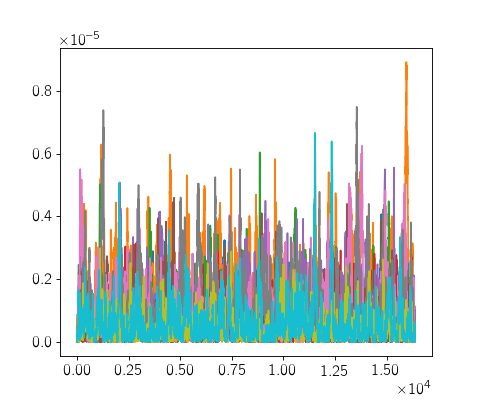

<IPython.core.display.Javascript object>


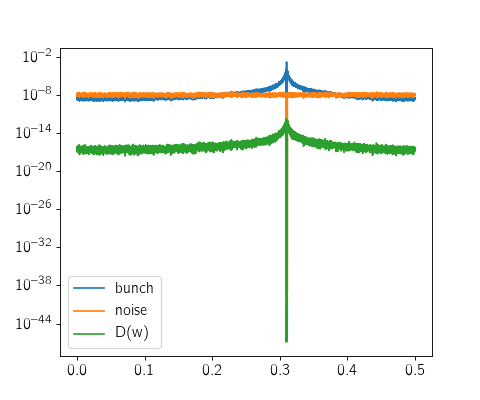

In [1311]:
plt.figure()
if Np>10:
    for i in range(min(10,Np)):
        plt.plot((x[:,i]**2+p[:,i]**2)*.5)
else:
    plt.plot(x**2+p**2)
    

plt.figure()
plt.plot(ff,pw2,label='bunch')
plt.plot(ff,Nw2,label='noise')
plt.plot(ff,Dw ,label='D(w)')
plt.yscale('log')
plt.legend(loc=0)


<IPython.core.display.Javascript object>


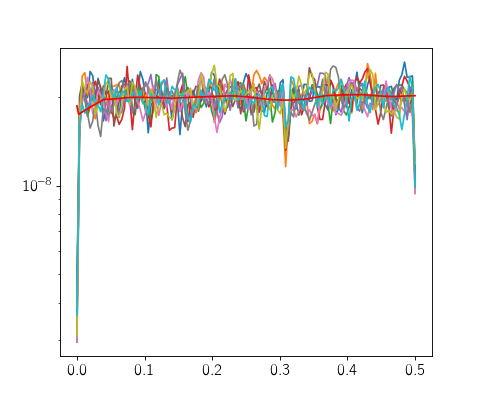

(129,) (16384, 10) (163840,)


<IPython.core.display.Javascript object>


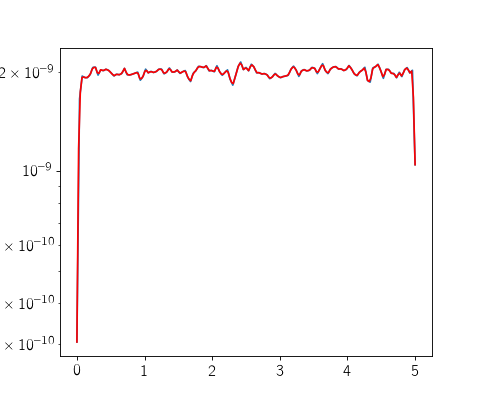

(129,) (16384, 10) (163840,)
1.654733978708001e-09


In [1312]:
for i in range(2):
    if i==0: ff,Nw2 = signal.welch(kicks,1/dt,axis=0)
    else:    ff,Nw2 = signal.welch(kicks.flatten(),1/(dt/Np))
    plt.figure(100+i)
    plt.semilogy(ff,Nw2)
    print(ff.shape,kicks.shape,kicks.flatten().shape)
    
    if i==1:
        print(Nw2[1])
#         Nw2[0]=2*Nw2[1]-Nw2[2]
        interp = sc.interpolate.interp1d(ff[0:],Nw2[0:],kind='linear',bounds_error=False,fill_value=(0))
        f2 = np.linspace(0,.5/dt,200)
        plt.semilogy(f2*Np,interp(f2*Np),'r')
        fs = 1/dt
        Nw3 = np.zeros_like(f2)
#         for j in range(0,Np+1,1):
#             print(j*fs)
#             for sign in [-1,1]:
#                 fi = j*fs +sign*f2
#                 Nw3 += interp(fi)
        
#         print(interp(f2*Np+100))
        fi = np.arange(Np)*fs
        for j,f in enumerate(f2):
            Nw3[j]+=np.sum(interp(fi+ f)) + np.sum(interp(fi-f))
                       
        plt.figure(100)
        plt.semilogy(f2,Nw3,'r')
#         print(f2,Nw3)

<IPython.core.display.Javascript object>


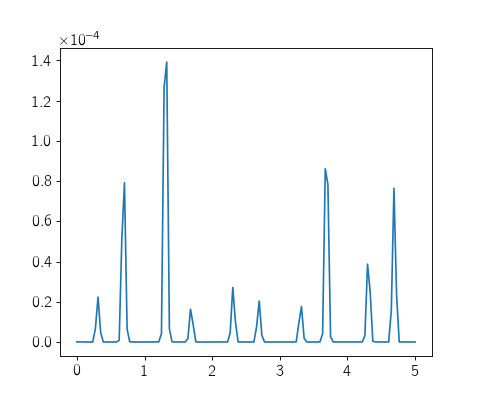

In [1317]:
# Multi bunch spectrum
if Np>1:
    beamt = x.flatten()
    f,beamf = signal.welch(beamt[Np*10:],Np/dt)
    plt.figure()
    plt.plot(f,beamf)
#     plt.plot(beamt)
    

<IPython.core.display.Javascript object>


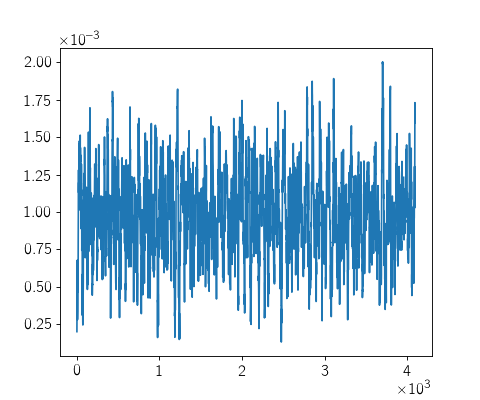

In [1058]:
plt.figure()
if Np>1:
    plt.plot(np.std((x**2+p**2),axis=1))
else:
    plt.plot(np.std((x**2+p**2)))

# plt.plot(turns,(turns*sigma_n**2))
# plt.plot(x)

<IPython.core.display.Javascript object>


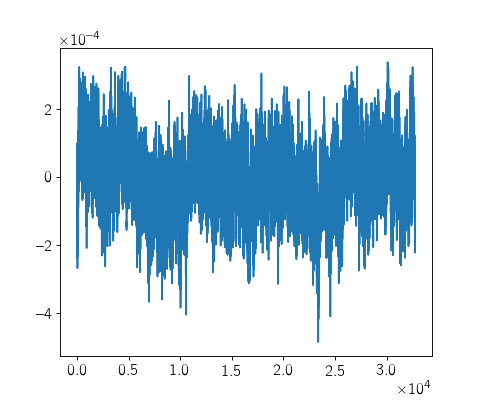

[0.00000000e+00 3.05175781e-03 6.10351562e-03 ... 4.99938965e+01
 4.99969482e+01 5.00000000e+01]


<IPython.core.display.Javascript object>


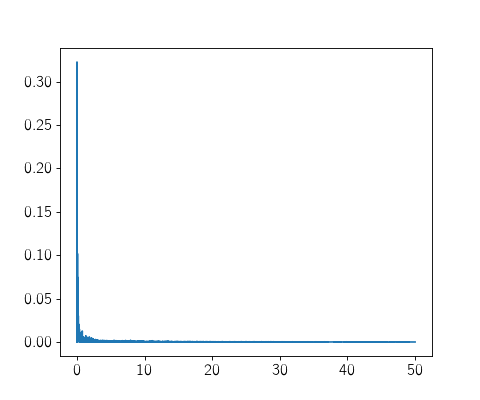

In [1203]:
plt.figure()
plt.plot(kicks.flatten())

N = Nt*Np

kfft = np.fft.rfft(kicks.flatten())
xfft = np.fft.rfft(x[:,0])
freq = np.fft.rfftfreq(N,d=dt)
print(freq)
plt.figure()
plt.plot(freq,np.abs(kfft)**2)
# plt.plot(freq,np.abs(xfft)**2)

<IPython.core.display.Javascript object>


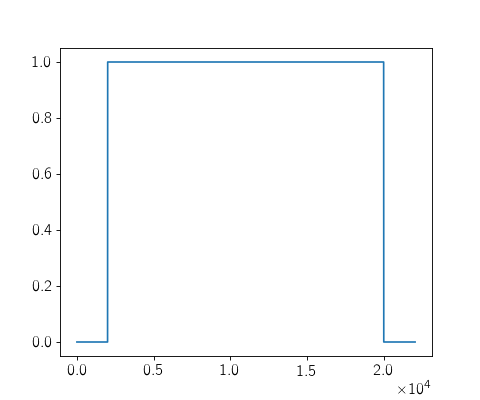

In [8]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

N = 44100
x = band_limited_noise(2000, 20000, N, N)
xfft = np.fft.rfft(x)
freq = np.fft.rfftfreq(N,d=1/N)
plt.figure()
plt.plot(freq,np.abs(xfft))